# Considerations for Activation Patching in IR
- reference to demo notebook and that it's meant to show an example of an end to end pipeline, but there are several degrees of freedom/"hyperparameters" that should be taken into consideration along the way. 
- this notebook enumerates all the functionality of the package, and also details things that should be taken into account when performing activation patching
- future work could/should be done to explore these options in more detail (could give ref to neel nanda's paper here too)
- bulleted list/outline/overview of considerations

## Setup 

This section just installs the necessary packages to run the code in this notebook and also defines some helper functions for better readability and visualizations.

Just run, don't read :)

In [13]:
%pip install .. # TODO: replace with pip install mechir
%pip install transformer_lens
%pip install matplotlib seaborn plotly streamlit

Processing /Users/cchen207/git/brown/research/MechIR
  Preparing metadata (setup.py) ... done
  Created wheel for mechir: filename=mechir-0.0.1-py3-none-any.whl size=71844 sha256=95301c551f8d697c067179a1a8bfd4e457594c798847245d9cac83af968ee872
  Stored in directory: /private/var/folders/w8/j9c1qwbx3cn8hf10x5nz_xtr0000gp/T/pip-ephem-wheel-cache-denbkqd7/wheels/39/37/7c/9f04c1e8f880bc1e666f79cde17d9e585bcff18fdf2b5a9b0d
Successfully built mechir
  Attempting uninstall: mechir
    Found existing installation: mechir 0.0.1
    Uninstalling mechir-0.0.1:
      Successfully uninstalled mechir-0.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [51]:
from mechir import Cat, Dot, MechIRDataset, DotDataCollator
from mechir.perturb import perturbation
from mechir.plotting import plot_components

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

### Helper Functions

In [9]:
# Helper function to print query/baseline document/perturbed document triplets
def pretty_print_triplets(batch, tokenizer, num=1):
    """
    Pretty prints triplets of queries, documents, and their corresponding perturbed documents from a batch.

    Args:
        batch (dict): A dictionary containing 'queries', 'documents', and 'perturbed_documents' from a DataLoader.
        tokenizer: The tokenizer used to decode the input IDs.
        num (int): Number of examples to show per batch.
    """
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    # Loop through number of examples to show in batch
    for i in range(len(documents["input_ids"][:num])):
        # Get the input IDs
        query_ids = queries["input_ids"][i]
        original_ids = documents["input_ids"][i]
        perturbed_ids = perturbed_documents["input_ids"][i]

        # Decode the input IDs to text
        query_decoded = tokenizer.decode(query_ids.tolist(), skip_special_tokens=False)
        original_doc_decoded = tokenizer.decode(original_ids.tolist(), skip_special_tokens=False)
        perturbed_doc_decoded = tokenizer.decode(perturbed_ids.tolist(), skip_special_tokens=False)

        # Pretty print
        # print(f"Triplet {i + 1}:")
        print("Query:", query_decoded)
        print("Baseline Document:", original_doc_decoded)
        print("Perturbed Document:", perturbed_doc_decoded)
        print("=" * 50)  # Separator for clarity

In [10]:
# Helper function to calculate and store performances
def calculate_performance(model, dataloader, baseline_performance, perturbed_performance):
    for i, batch in enumerate(dataloader):
        # Get the queries, documents, and perturbed documents from the batch
        queries = batch["queries"]
        documents = batch["documents"]
        perturbed_documents = batch["perturbed_documents"]

        # Encode queries, baseline, and perturbed documents
        queries_encoded = model._forward(**queries)  # [batch_size x hidden_dim]
        baseline_encoded = model._forward(**documents)  # [batch_size x hidden_dim]
        perturbed_encoded = model._forward(**perturbed_documents)  # [batch_size x hidden_dim]

        # Calculate scores
        baseline_scores = torch.sum(queries_encoded.unsqueeze(1) * baseline_encoded.unsqueeze(0), dim=2)
        perturbed_scores = torch.sum(queries_encoded.unsqueeze(1) * perturbed_encoded.unsqueeze(0), dim=2)

        # Append flattened scores to the performance lists
        baseline_performance += baseline_scores.flatten().tolist()
        perturbed_performance += perturbed_scores.flatten().tolist()

In [33]:
# For multiple perturabations
def plot_score_dists_mult(all_baseline_scores, all_perturbed_scores, plot_type="hist"):
    # Number of subplots (one per perturbation type)
    num_plots = len(all_baseline_scores)
    
    # Set up the figure to hold multiple subplots in a single row
    fig, axs = plt.subplots(1, num_plots, figsize=(15, 4), sharey=True)
    fig.suptitle('Distribution of Baseline vs Perturbed Scores', fontsize=16)
    
    for idx, (perturb_type, ax) in enumerate(zip(all_baseline_scores.keys(), axs)):
        baseline_scores = all_baseline_scores[perturb_type]
        perturbed_scores = all_perturbed_scores[perturb_type]
        
        if plot_type == "hist":
            ax.hist(baseline_scores, label='Baseline', color='blue', alpha=0.5, bins=15)
            ax.hist(perturbed_scores, label='Perturbed', color='orange', alpha=0.5, bins=15)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel('Frequency')
            ax.legend()
        elif plot_type == "kde":
            # Use seaborn for KDE plot, smoother distribution representation
            sns.kdeplot(baseline_scores, label='Baseline', color='#D55E00', fill=True, ax=ax, alpha=0.5)
            sns.kdeplot(perturbed_scores, label='Perturbed', color='#009E73', fill=True, ax=ax, alpha=0.5)
            ax.set_ylabel('Density')
            ax.legend()
        elif plot_type == "box":
            ax.boxplot([baseline_scores, perturbed_scores], tick_labels=['Baseline', 'Perturbed'])
            ax.set_ylabel('Scores')
        
        ax.set_xlabel('Scores')
        ax.set_title(f'{perturb_type.capitalize()}')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

    return

## Accessing Model Activations

- make a table of all supported IR models then load one bi-encoder and one cross-encoder to showcase differences for rest of notebook

If you want to add your own model that we don't support, you should test:
- The weights have been loaded correctly from huggingface into hooked model
- The embeddings/outputs are the same / similar enough to original 
(TODO: add automated testing after submission)

(should we even include this for the demo? I don't think right now we support adding custom architechtures rn so maybe we skip this last bit)

In [55]:
# Load model
dot_model_name = "sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco"
dot_model = Dot(dot_model_name)

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco into HookedEncoder


## Paired Dataset Creation
- activation patching relies on pairs of inputs
- in main demo, we show one type of perturbation but there could be others
- here we discuss some possible methods for creating the pairs (append, prepend, replacement) and considerations for perturbation methods (pairs must be positionally aligned)
- show examples of triplets for different types of perturbations
- detail the built in axiomatic perturbations (term frequency, proximity)
- instructions on how to create custom perturbations

In [50]:
# For demonstration purposes, look at two queries
dataset = MechIRDataset("vaswani", query_id_subset=["1", "2"])
print("Number of query,doc pairs in dataset:", len(dataset))
print("Query:", dataset._get_query("1"))
print("Query:", dataset._get_query("2"))
dataset.pairs.head()

Number of query,doc pairs in dataset: 34
Query: MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES

Query: MATHEMATICAL ANALYSIS AND DESIGN DETAILS OF WAVEGUIDE FED MICROWAVE RADIATIONS



,query_id,doc_id,relevance,iteration
0,1,1239,1,0
1,1,1502,1,0
2,1,4462,1,0
3,1,4569,1,0
4,1,5472,1,0


In [73]:
# Define perturbations
@perturbation
def append(text):
    return text + " microwave"

@perturbation
def prepend(text):
    return "microwave " + text

@perturbation
def replace(text):
    return text.replace("microwave", "toaster")

In [74]:
prepend_dot_collator = DotDataCollator(dot_model.tokenizer, prepend, q_max_length=None, d_max_length=None, perturb_type="prepend")
prepend_dot_dataloader = DataLoader(dataset, batch_size=12, collate_fn=prepend_dot_collator)

append_dot_collator = DotDataCollator(dot_model.tokenizer, append, q_max_length=None, d_max_length=None, perturb_type="append")
append_dot_dataloader = DataLoader(dataset, batch_size=12, collate_fn=append_dot_collator)

replace_dot_collator = DotDataCollator(dot_model.tokenizer, replace, q_max_length=None, d_max_length=None, perturb_type="replace")
replace_dot_dataloader = DataLoader(dataset, batch_size=12, collate_fn=replace_dot_collator)

In [81]:
# Get a single pair from each perturbation type just to visualize
prepend_batch = next(iter(prepend_dot_dataloader))
append_batch = next(iter(append_dot_dataloader))
replace_batch = next(iter(replace_dot_dataloader))

print("PREPEND")
pretty_print_triplets(prepend_batch, dot_model.tokenizer, num=2)

print("\nAPPEND")
pretty_print_triplets(append_batch, dot_model.tokenizer, num=2)

print("\nREPLACE")
pretty_print_triplets(replace_batch, dot_model.tokenizer, num=2)

PREPEND
Query: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

### Verify Difference in Performance on Perturbed Pairs
- before proceeding with experiments, need to determine (1) if there's a signal to begin with and (2) which has the higher performance on average 
- show plot with all perturbation types to show that special consideration should be taken with perturbation type depending on use case

In [76]:
# Initialize lists to store baseline and perturbed performances for each dataloader
all_baseline_performance = {"prepend": [], "append": [], "replace": []}
all_perturbed_performance = {"prepend": [], "append": [], "replace": []}

# Calculate performances for each perturbation_type
calculate_performance(dot_model, prepend_dot_dataloader, all_baseline_performance["prepend"], all_perturbed_performance["prepend"])
calculate_performance(dot_model, append_dot_dataloader, all_baseline_performance["append"], all_perturbed_performance["append"])
calculate_performance(dot_model, replace_dot_dataloader, all_baseline_performance["replace"], all_perturbed_performance["replace"])


Here, we see that there are slight differences in the effect of different perturbations. 

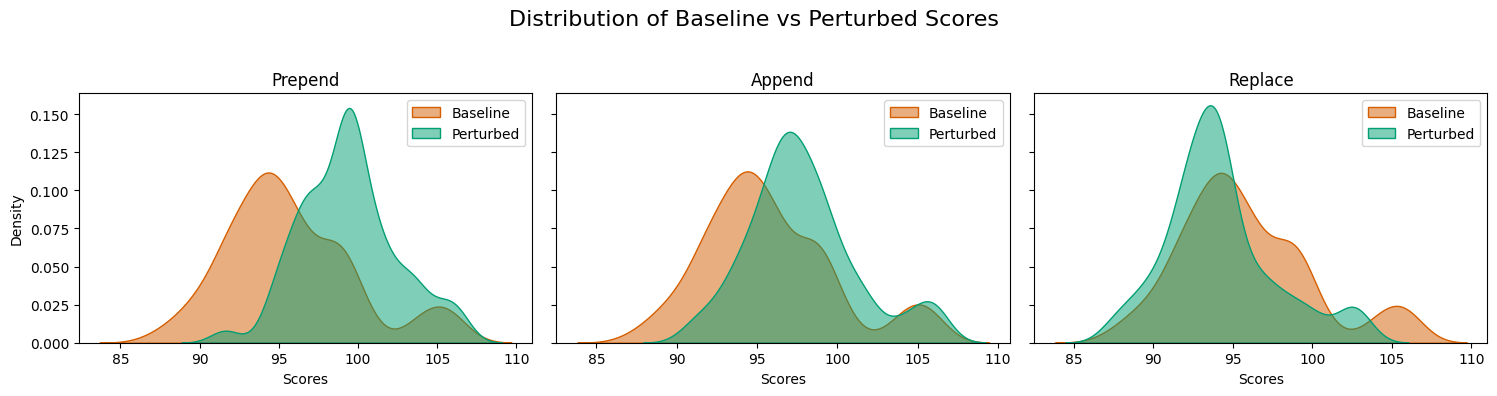

In [77]:
plot_score_dists_mult(all_baseline_performance, all_perturbed_performance, plot_type="kde")

## Activation Patching
- introduce different types of patching: (1) blocks (over individual positions) and (2) attention heads (over all or individual positions) - won't go through code for each scenario, but could give example code to run the patching at the end?
- note that this is an indirect causal effect, support for direct causal effect (i.e., path patching) will come in the future
- consideration here is the direction of the patch (i.e., baseline into perturbed or vice versa) and the evaluation metric
- in above case, prepend and append perturbations increases the score so you would patch perturbed into baseline, but imagine a scenario where a perturbation may cause the score to drop (e.g., removal of certain words). in that scenario, you would patch baseline into perturbed
- metric will be different depending on model type (logit difference vs. dot product) - we don't include probability because it may be incapable of discovering certain components in certain settings (cite neel nanda's best practices paper)

In [27]:
# For time/memory sake, use one perturbation type
patching_head_outputs = []
for i, batch in enumerate(prepend_dot_dataloader):
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    # patch_block_out = model(queries, documents, queries, perturbed_documents, patch_type="block_all")
    # TODO: keep track of query and document ids in order to save results?
    # essentially need something to save query and document labels

    patch_head_out = dot_model(queries, documents, queries, perturbed_documents, patch_type="head_all")
    patching_head_outputs.append(patch_head_out)

    # For testing, just patch a couple batches
    if i == 5:
        break
    
mean_head_outputs = torch.mean(torch.stack(patching_head_outputs), axis=0)

100%|██████████| 6/6 [00:21<00:00,  3.65s/it]


## Case Study
- more in depth experimental analysis from demo experiment?

## Conclusion
- overview and hopes for future research
- pointers to relevant literature/tutorials/resources